# DELETWEET TEXT MINING

***
## *DATASET*

There are 67,763 tweets in this subset of the [Politwoops](https://projects.propublica.org/politwoops/) dataset, which is a collection of tweets deleted by US politicians while they were in office. The tweets in the dataset analyzed here were gathered from Nov. 17, 2011 - Feb 3, 2017. The database contains 11 fields:

* id: unique id for the tweet [int]
* user_name: twitter username, or author, of the tweet [str]
* content: text content of the tweet [str]
* created: date tweet was originally created [str; format ‘%m/%d/%Y %H:%M:S’]
* modified: date tweet was last modified, in this case deleted [str; format ‘%m/%d/%Y %H:%M:S’]
* tweet: the original tweet object from the Twitter Streaming API [json]
* state: two letter code for politician's state [str]
* party_id - number corresponding to politician's political party [int]
  * 1 - Democrat
  * 2 - Republican
  * 3 - Independent
  * 4 - Other
* last_name - politician's last name [str]
* first_name - politician's first name [str]
* middle_name - politician's middle name [str]

In [1]:
import json
import pandas
import nltk
import matplotlib
from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]

***
## *IMPORT AND DESCRIBE*

Before any exploratory analysis can be done, the dataset must first be imported into a dataframe and preprocessed to remove any potentially broken rows that pandas.read_csv() may have missed.

In [2]:
# import dataset and remove bad rows
deletweet = pandas.read_csv('../../deletweet/data/deleted_tweets.csv', error_bad_lines=False)

bad_rows = []

for i in range(len(deletweet)):
    if type(deletweet['tweet'][i]) != str:
        bad_rows.append(i)
    else:
        tweet = json.loads(deletweet['tweet'][i])
        if type(tweet) != dict:
            bad_rows.append(i)

deletweet.drop(deletweet.index[bad_rows], inplace=True)
deletweet.reset_index(inplace=True, drop=True)

# export cleaned dataframe to csv to allow easier future importing
# deletweet.to_csv('../../deletweet/data/deleted_tweets_cleaned.csv', index=False)

b'Skipping line 1157: expected 11 fields, saw 141\nSkipping line 2263: expected 11 fields, saw 77\nSkipping line 2319: expected 11 fields, saw 92\nSkipping line 4631: expected 11 fields, saw 129\nSkipping line 8260: expected 11 fields, saw 89\nSkipping line 8823: expected 11 fields, saw 84\nSkipping line 8824: expected 11 fields, saw 129\nSkipping line 10197: expected 11 fields, saw 131\nSkipping line 10278: expected 11 fields, saw 123\nSkipping line 10297: expected 11 fields, saw 123\nSkipping line 10311: expected 11 fields, saw 123\nSkipping line 10401: expected 11 fields, saw 79\nSkipping line 10430: expected 11 fields, saw 154\nSkipping line 10495: expected 11 fields, saw 92\nSkipping line 12989: expected 11 fields, saw 77\nSkipping line 14473: expected 11 fields, saw 73\nSkipping line 16741: expected 11 fields, saw 79\nSkipping line 22015: expected 11 fields, saw 81\nSkipping line 22322: expected 11 fields, saw 123\nSkipping line 22957: expected 11 fields, saw 74\nSkipping line 24

A simple describe() gives us an informative overview of the features in the dataset.

For example we can see that each tweet's id is unique, which means we can use it as a unique identifier if needed. This also shows us that we have 67,756 tweets in the dataset, which means we lost only 7 tweets in the above cleaning process. The 'content' field shows us that not every tweet's text is unique, and in fact the most frequently deleted tweet has been posted and taken down 74 times. The state with the most deleted tweets is California, which makes sense as it is one of the most populous states in the US, and as such has a proportionally high number of elected officials. The political party with the most deletions is Republican.

The fields 'first_name', 'last_name', and 'user_name' yield some interesting information: the most common first name, Tim, obviously represents more than one politician in the dataset since the 2,315 deletions attributed to Tim are more than the 1,310 deletions by the most common username in the dataset. But the combination of the most common first and last name - Tim Griffin - does actually correspond to the most frequently appearing username: TGforArkansas. As we'll see later, one of the most frequent terms in the processed dataset (with stopwords and punctuation removed) is the hashtag #tg4lg, which is an acronym fpr 'Tim Griffin for Lieutenant Governor'.

In [3]:
deletweet.describe()

,id,user_name,content,created,modified,tweet,state,party_id,last_name,first_name,middle_name
count,67756,67756,67756,67756,67756,67756,67353,67756,67754,67754,5076
unique,67756,1647,67030,67475,61895,67756,54,7,948,465,36
top,263357835860123648,TGforArkansas,"RT @derGeruhn: &lt;script class=""xss""&gt;$('.x...",05/26/2015 18:52:43,06/29/2012 17:40:36,"{""contributors"": null, ""truncated"": false, ""te...",CA,2,Griffin,Tim,Bernie
freq,1,1310,74,5,10,1,5854,32911,1667,2315,1048


***
## *RETWEETS*

The distinction between retweets and original tweets is an important one in the context of this dataset. A retweet can happen in several different ways, the two most common being:
 * the user retweets a tweet via Twitter's official retweet functionality
 * the user copy and pastes the text of another user's tweet, usually prefaced by 'RT'
 
The difference between these retweet styles is that, in the case of the first, the retweet is tracked by the Twitter API via the presence of a 'retweeted_status' attribute in the Tweet object (reference: [twitter api](https://dev.twitter.com/overview/api/tweets)). In the case of the second, the tweet is not officially tracked as a retweet, and is therefore only identifiable as such if the author prepends 'RT' to the tweet's quoted text (reference: [quora](https://www.quora.com/Twitter-product-If-a-tweet-is-deleted-are-all-its-retweets-also-deleted)).

This has particular relevance to the analysis of this dataset, as the manner of retweet subjects the tweet to different deletion policies. In the case of the first, official retweet, if the original tweet is deleted by the original author, then the retweet is also deleted. This means that if the original tweet is deleted, any retweets will appear in this dataset as deletions by the retweeting user, *even though that user did not explicitly delete their retweet*.

However in the second instance - since the retweet appears to the Twitter API to be an original tweet, not tied to any preceding tweet - the retweet will remain even if the original tweet is deleted, and can only be deleted by the retweeting author. This type of deletion carries more significance than the first, since it is a deliberate choice by the retweeting user to disassociate themselves from the original tweet by deleting their retweet.

In [4]:
# count number of retweets in dataset by counting the presence of 'retweeted_status' object in tweet object
retweet_count = 0

for i in range(len(deletweet)):
    tweet = json.loads(deletweet['tweet'][i])
    if 'retweeted_status' in tweet.keys():
        retweet_count += 1
        
print(retweet_count)

15924


In [5]:
# retweets as percentage of total tweets
print('{:.1%}'.format(retweet_count / len(deletweet)))

23.5%


There are 15,942 official retweets, which is almost 1/4 of the original dataset. These 15,942 are ambiguous deletions in that they could have potentially been deleted by either the original tweet's author, or the retweeting user.

As we will see further below, the token 'rt' is the most frequently occuring token in the normalized dataset, with 17,591 instances. This suggests that there are 1,649 tweets in the dataset that may be unofficial retweets, wherein the original tweet's text is copy and pasted, and 'RT' is prepended. These 1,600+ retweets were most likely deleted by the retweeting user rather than the original author.

***
## *PARSE AND TOKENIZE TEXT*

In [6]:
# construct a list of strings to hold the tweet text
tweet_text_raw = []

for i in range(len(deletweet)):
    tweet = json.loads(deletweet['tweet'][i])
    tweet_text_raw.append(tweet['text'])

In [7]:
# number of individual tweets in the dataset
len(tweet_text_raw)

67756

In [8]:
# construct one long string of the dataset's tweet content
tweet_string = ' '.join(tweet_text_raw)

In [9]:
# tokenize text via the tweet tokenizer provided by NLTK
# preserve_case=False will transform all to lowercase
# strip_handles=True will remove all Twitter usernames from the text (i.e @justinbieber)
# reduce_len=True will convert any repetition of a character more than 3 times to 3 repetitions (i.e. nooooo -> nooo)
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokenized = tknzr.tokenize(tweet_string)

In [10]:
# convert to NLTK text object for analysis
text = nltk.Text(tweet_tokenized)

In [11]:
# remove stopwords, punctuation
stopwords = nltk.corpus.stopwords.words('english')
punctuation_etc = ['.', ':', ',', '!', '"', '-', '…', '...', "’", '?', '/', "'", '(', ')', '“', '”', '&', '%']
filtered = [w for w in tweet_tokenized if w.lower() not in stopwords]
filtered = [w for w in filtered if w.lower() not in punctuation_etc]

processed = []

# remove numbers from the text -> results in roughly 1,000 less unique words
for i in range(len(filtered)):
    try:
        float(filtered[i])
    except ValueError:
        processed.append(filtered[i])

# convert to NLTK text object for analysis
text_normalized = nltk.Text(processed)

***
## *ANALYSIS*

### *ORIGINAL TEXT (BEFORE NORMALIZATION)*

In [12]:
# number of tokens
len(text.tokens)

1227667

In [13]:
words = [w.lower() for w in text]
vocab = sorted(set(words))

# number of unique words
len(vocab)

102551

In [14]:
# lexical diversity
print('{:.2%}'.format(len(vocab) / len(words)))

8.35%


In [15]:
# words frequently appearing together in the text
text.collocations()

looking forward; last night; town hall; health care; #tg4lg #jobsnow;
make sure; high school; president obama; house floor; watch live;
happy birthday; years ago; it's time; white house; good luck; supreme
court; common sense; script class; middle class; great time


### *NORMALIZED TEXT*

In [16]:
# percentage of text remaining after normalizing
print('{:.2%}'.format(len(text_normalized) / len(text)))

56.01%


In [17]:
# number of tokens in normalized text
len(text_normalized.tokens)

687568

In [18]:
words_normalized = [w.lower() for w in text_normalized]
vocab_normalized = sorted(set(words_normalized))

# of unique words in normalized text
len(vocab_normalized)

100998

In [19]:
# lexical diversity
print('{:.2%}'.format(len(vocab_normalized) / len(words_normalized)))

14.69%


In [20]:
# words frequently appearing together in the text
text_normalized.collocations()

looking forward; last night; town hall; video playlist; added video;
health care; #tg4lg #jobsnow; thoughts prayers; high school; make
sure; watch live; president obama; photo facebook; house floor; happy
birthday; years ago; posted new; it's time; good luck; white house


### *FREQUENCIES*

In [21]:
# construct frequency distributions for original and processed texts
fdist = nltk.FreqDist(text)
fdist_normalized = nltk.FreqDist(text_normalized)

In [22]:
# most common words in original text
common_50 = fdist.most_common(50)
pandas.Series([common_50[i][1] for i in range(len(common_50))], index=[common_50[i][0] for i in range(len(common_50))])

.        50706
the      36453
to       35796
:        31383
,        22924
in       19005
!        17630
rt       17591
for      17011
of       16543
a        15379
and      13102
on       12671
at        9034
&         8852
i         8481
is        8119
you       7652
"         7642
with      7485
my        6189
this      6128
our       5936
today     5876
-         5362
…         5274
we        5098
...       4698
s         4615
be        4372
from      4273
’         4115
?         4058
will      4055
/         4036
great     3977
it        3649
your      3446
'         3436
are       3422
that      3406
about     3349
by        3198
have      3145
w         3130
(         2721
out       2683
more      2643
new       2540
as        2428
dtype: int64

In [23]:
# most common words in normalized text
# these are a vast improvement from the unfiltered corpus for determining overall content
normalized_50 = fdist_normalized.most_common(50)
pandas.Series([normalized_50[i][1] for i in range(len(normalized_50))], index=[normalized_50[i][0] for i in range(len(normalized_50))])

rt           17591
today         5876
great         3977
w             3130
new           2540
day           2288
thanks        2286
us            2262
support       2241
$             2198
house         2056
thank         1993
time          1985
vote          1954
help          1733
join          1695
bill          1621
get           1527
watch         1484
congress      1450
proud         1402
work          1402
need          1399
live          1332
morning       1329
see           1287
tonight       1277
state         1264
people        1254
rep           1250
president     1246
act           1241
it's          1215
good          1194
one           1175
last          1164
jobs          1155
i'm           1140
make          1135
happy         1117
#tg4lg        1095
county        1088
via           1085
obama         1076
first         1060
senate        1034
http          1034
meeting       1030
women         1019
like          1012
dtype: int64

In [24]:
# words longer than 3 characters occurring more than 500 times in normalized text
pandas.Series([fdist_normalized[thing] for thing in sorted(word for word in set(text_normalized) if len(word) > 3 and fdist_normalized[word] > 750)], index=[thing for thing in sorted(word for word in set(text_normalized) if len(word) > 3 and fdist_normalized[word] > 750)])

#tg4lg       1095
american      816
bill         1621
campaign      835
check         885
congress     1450
county       1088
discuss       829
family        754
first        1060
good         1194
great        3977
happy        1117
health        943
help         1733
honor         793
honored       775
house        2056
http         1034
it's         1215
jobs         1155
join         1695
last         1164
like         1012
live         1332
make         1135
meeting      1030
morning      1329
must          915
national      870
             ... 
people       1254
please        930
president    1246
proud        1402
read          906
right         790
senate       1034
state        1264
stop          817
students      782
support      2241
take          804
talk          762
team          800
thank        1993
thanks       2286
time         1985
today        5876
tomorrow      870
tonight      1277
tune          840
video        1007
vote         1954
watch        1484
week      

In [25]:
# frequency distribition of the frequencies of word lengths
dist_of_dist = nltk.FreqDist(len(w) for w in text)
dist_of_dist_normalized = nltk.FreqDist(len(w) for w in text_normalized)

In [26]:
# most common word length in original text
dist_of_dist.max()

1

In [27]:
# words of length 1 as percentage of total words in original text
print('{:.2%}'.format(dist_of_dist.freq(1)))

18.26%


In [28]:
# most common word length in normalized text
dist_of_dist_normalized.max()

5

In [29]:
# words of length 5 as percentage of total words in normalized text
print('{:.2%}'.format(dist_of_dist_normalized.freq(5)))

15.62%


***
## *GRAPHS*

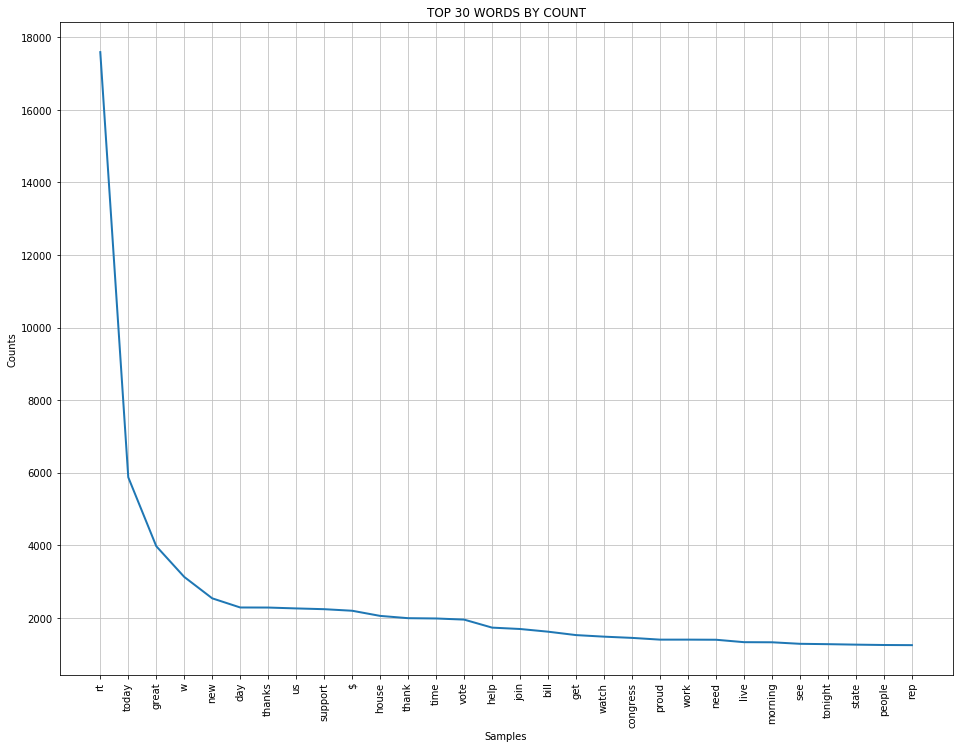

In [30]:
# 30 most frequent words in normalized text by count
fdist_normalized.plot(30, title='TOP 30 WORDS BY COUNT')

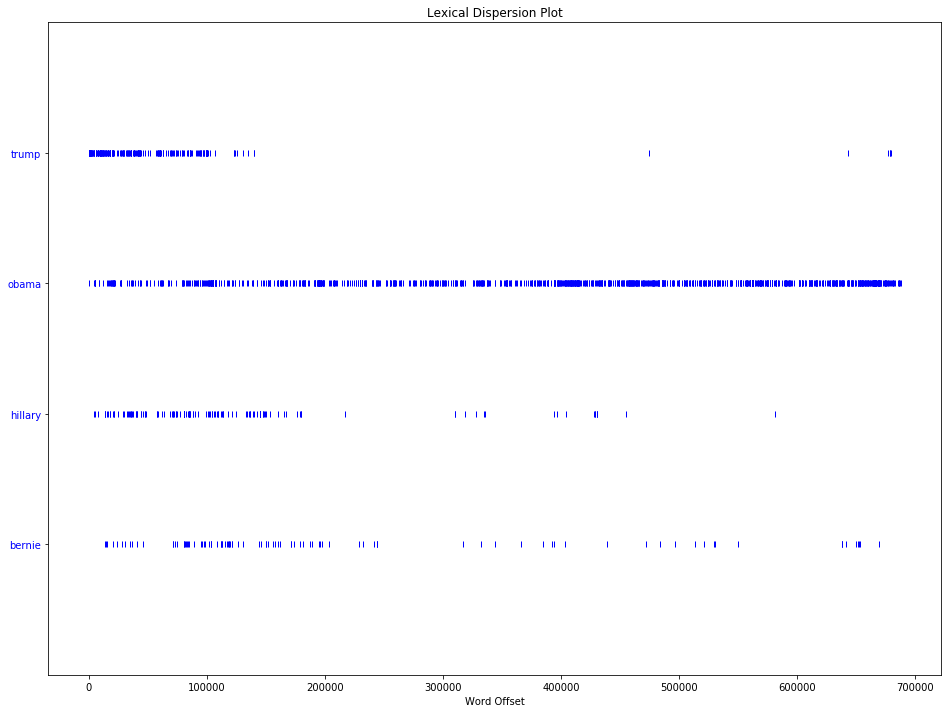

In [31]:
# lexical dispersion plot
# shows use of 4 names over time
# 0 on x-axis is February 2017
# 700,00 on x-axis is November 2011

politicians = ['trump', 'obama', 'hillary', 'bernie']
text_normalized.dispersion_plot(politicians)

(-0.5, 1599.5, 1199.5, -0.5)

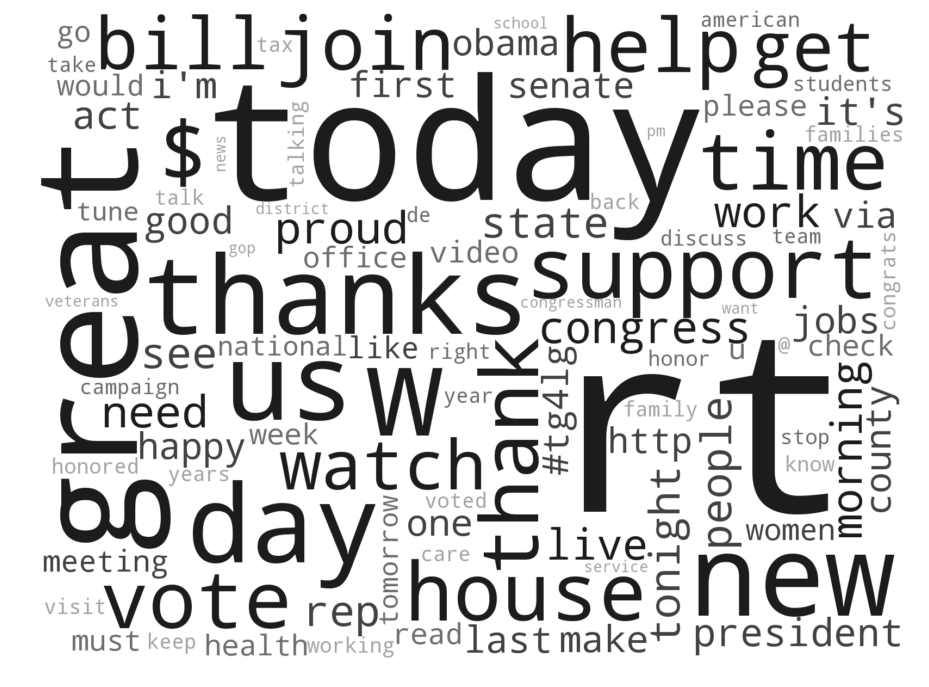

In [32]:
# generate wordcloud out of 100 most frequent words in normalized text;
# 4 shades of color where color intensity is positively correlated with word frequency

colors = ['#1C1C1C', '#424242', '#6E6E6E', '#A4A4A4']
common = fdist_normalized.most_common(100)
common_list = [common[i][0] for i in range(len(common))]
common_dict = {colors[0]: common_list[0:25], colors[1]: common_list[25:50], colors[2]: common_list[50:75], colors[3]: common_list[75:100]}

# more info on coloring wordcloud by group: http://amueller.github.io/word_cloud/auto_examples/colored_by_group.html
def grey_color_func(word, font_size, position, orientation, random_state=None, color_dict=common_dict, **kwargs):
    for key in color_dict.keys():
        if word in color_dict[key]:
            return key

wordcloud = WordCloud(width=1600, height=1200, background_color='white', color_func=grey_color_func, collocations=False).generate_from_frequencies(dict(common))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

***
## *CONCLUSION*

Normalizing the text by removing punctuation and stopwords was absolutely essential here, as can be seen most clearly through the comparison of the most frequent words in the original text v. the normalized text.

The 50 most frequent words in the original text consist entirely of punctuation, articles, prepositions, and other basic infrastructure of the English language. As such they contain little to no information about the nature of the dataset, or its contents.

On the other hand, the 50 most frequent words in the normalized text are very descriptive, and give an informative look into the dataset. The most frequently occuring term - 'rt' - immediately identifies the dataset as Twitter data, as that is a domain-specific term related to tweets. Other terms such as 'video', '#tg4lg', and 'http' identify the dataset as originating from social media.

Words such as 'american', 'bill', 'congress', 'county', 'obama', 'president', 'senate', and 'vote' identify the dataset as political in nature. Terms like 'family', 'healthcare', 'jobs', 'obama', 'students', 'women', and 'work' speak to the most important issues in the dataset.